In [1]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import os
import numpy as np
import wavemix.sisr as sisr
from PIL import Image
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_path = Path.cwd() / "data"

train_data_folder = data_path/"DIV2K/DIV2K_train_LR_bicubic/X2"
test_data_folder = data_path/"DIV2K/DIV2K_valid_LR_bicubic/X2"

train_data_targest_folder = data_path/"DIV2K/DIV2K_train_HR"
test_data_targest_folder = data_path/"DIV2K/DIV2K_valid_HR"

In [4]:
class WaveMixSR(nn.Module):
    def __init__(
        self,
        *,
        depth,
        mult = 1,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.3,
        scale_factor = 2
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(sisr.Level1Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))
        
        self.final = nn.Sequential(
            nn.Conv2d(final_dim,int(final_dim/2), 3, stride=1, padding=1),
            nn.Conv2d(int(final_dim/2), 1, 1)
        )


        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners = False),
            nn.Conv2d(1, int(final_dim/2), 3, 1, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 1, 1)
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=int(scale_factor), mode='bilinear', align_corners = False),
        )

    def forward(self, img):

        y = img[:, 0:1, :, :] 
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)


        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)
        
        return  torch.cat((y,crcb), dim=1)

In [5]:
weights = torch.load('weights.pth', map_location=device)

C:\Users\warre\AppData\Local\Temp\ipykernel_25572\537843689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('weights.pth', map_location=device)


In [6]:
model = WaveMixSR(depth = 4, mult = 1, ff_channel = 144, final_dim = 144, dropout = 0.3, scale_factor = 2).to(device)
model.load_state_dict(weights)

<All keys matched successfully>

Image size: (1020, 708)


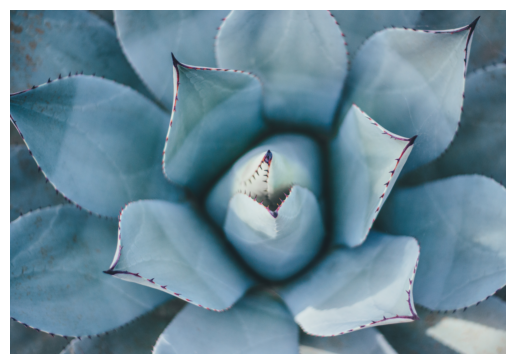

Output size: (1416, 2040, 3)


In [7]:
random_image = random.choice(os.listdir(test_data_folder))
random_image_path = test_data_folder/random_image
img = Image.open(random_image_path)
print(f"Image size: {img.size}")
img = torchvision.transforms.ToTensor()(img)
img = img.unsqueeze(0)
img = img.to(device)

model.eval()
with torch.no_grad():
    output = model(img)
    output = output.squeeze(0)
    output = output.to('cpu')
    output = output.detach().numpy()
    output = output.transpose(1,2,0)
    output = np.clip(output, 0, 1)
    output = (output*255).astype(np.uint8)

plt.imshow(output)
plt.axis('off')
plt.show()
print(f"Output size: {output.shape}")